In [51]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(os.listdir("../input"))

['.DS_Store', 'test.csv', 'train.csv']


In [52]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [121]:
# Use Keras Tensorflow deeplearning library
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras
set_random_seed(123)
random.seed(123)

In [122]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from matplotlib.pylab import rcParams

from sklearn.metrics import roc_curve,auc,make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import eli5 # for permutation importance
from eli5.sklearn import PermutationImportance

import shap # for SHAP value
from pdpbox import pdp, info_plots # flor partial plots 

np.random.seed(123)
pd.options.mode.chained_assignment = None  #hide any pandas warnings
%matplotlib inline

In [54]:
# Load Dataset
train= pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

train.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [55]:
# pip install ftfy
# import ftfy
# ftfy.fix_text(train[train['tweet']])

In [56]:
train.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [57]:
# Train dataset: Need only class as "Sentiment" and text as 'Phrase'
train = train.rename(columns={'class':'Sentiment','tweet':'Phrase'})
train = train.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1).copy()
train.head()

,Sentiment,Phrase
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [58]:
test.head()

,Text,Date,Favorites,Retweets,Tweet ID
0,Nielson Media Research final numbers on ACCEPT...,7/30/16 23:32,13850,4130,7.600000e+17
1,Thank you to all of the television viewers tha...,7/30/16 19:00,27659,6842,7.600000e+17
2,Can you imagine if I had the small crowds that...,7/30/16 18:28,19968,6488,7.600000e+17
3,NATO commander agrees members should pay up vi...,7/30/16 18:24,11624,4668,7.600000e+17
4,"Wow, NATO's top commander just announced that ...",7/30/16 18:18,23922,7819,7.600000e+17


In [59]:
test.columns

Index(['Text', 'Date', 'Favorites', 'Retweets', 'Tweet ID'], dtype='object')

In [60]:
# Test dataset: Need only text as 'Phrase'
test = test.rename(columns={'Text':'Phrase'})
test = test.drop(['Date', 'Favorites', 'Retweets', 'Tweet ID'],axis=1).copy()
test.head()

,Phrase
0,Nielson Media Research final numbers on ACCEPT...
1,Thank you to all of the television viewers tha...
2,Can you imagine if I had the small crowds that...
3,NATO commander agrees members should pay up vi...
4,"Wow, NATO's top commander just announced that ..."


In [61]:
train.shape

(24778, 2)

In [62]:
train.dtypes

Sentiment     int64
Phrase       object
dtype: object

In [63]:
test.shape

(29886, 1)

In [64]:
test.dtypes

Phrase    object
dtype: object

In [65]:
# Clean tweets, tokenize, and lemmatize
#     remove html content
#     remove non-alphabetic characters
#     tokenize the sentences
#     lemmatize each word to its lemma (the basic or stem of that word)
        # ex) playing --> play

In [69]:
def clean_sentences(df):
    tweets = []
    
    for sent in tqdm(df['Phrase']):
        
        # remove non-alphabetic characters
        tweet_text = tweet_text = re.sub("[^a-zA-Z]"," ", str(sent))
        
        #remove html content
        tweet_text = BeautifulSoup(tweet_text).get_text()
        
        # tokenize
        words = word_tokenize(tweet_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        tweets.append(lemma_words)
        
    return(tweets)

In [67]:
# cleaned tweets for both train and test set retrieved

train_sentences = clean_sentences(train)

100%|██████████| 24778/24778 [00:08<00:00, 2804.91it/s]


In [70]:
test_sentences = clean_sentences(test)

100%|██████████| 29886/29886 [00:11<00:00, 2632.48it/s]


In [71]:
print(len(train_sentences))
print(len(test_sentences))

24778
29886


In [74]:
train_sentences[1]

['rt',
 'mleew',
 'boy',
 'dat',
 'cold',
 'tyga',
 'dwn',
 'bad',
 'for',
 'cuffin',
 'dat',
 'hoe',
 'in',
 'the',
 'st',
 'place']

In [89]:
test_sentences[1000]

['heading',
 'to',
 'rally',
 'with',
 'bobby',
 'now',
 'see',
 'you',
 'soon',
 'pic',
 'twitter',
 'com',
 'dwssoectzn']

In [96]:
# Collect dependent values and convert to ONE-HOT encoding
# Output using to_categorical
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [97]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [98]:
# Getting the no of unique words and max length of a tweet available in the list of cleaned tweets
# It is needed for initializing tokenizer of keras and subsequent padding

# Build an unordered collection of unique elements.
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max=len(sent)

# length of the list of unique_words gives the no of unique words

print(len(list(unique_words)))
print(len_max)


100%|██████████| 19822/19822 [00:00<00:00, 493342.12it/s]

28853
53


In [99]:
# Actual tokenizer of keras and convert to sequences

tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

# texts_to_sequences
# ARGUMENTS: list of texts to turn to sequences
# RETURN: list of sequences (one per text input)

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [100]:
# Padding is done to equalize the lengths of all input tweets.
# LTSM networks need all inputs to be same length.
# Therefore, tweets lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(19822, 53) (4956, 53) (29886, 53)


In [101]:
# Early stopping to prevent overfitting deep learning neural network models
# This is a method that allows you to specify an arbitrary large number of training epochs.
# This stops training once the model performance stops improving on a hold out validation dataset


early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor = 'val_acc', patience = 2)
callback = [early_stopping]


In [129]:
# Model with Keras LSTM
# Multilayer Perceptron (MLP) for multi-class softmax classification
# Build NLP model called: Long Short Term Memory Network
# This model works on sequenced data
# It's good for NLP task like tagging and text classification
# It treats text as a sequence rather than a bag of words or as ngrams

In [130]:
# Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer='uniform',
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs,
# )

# LSTM(
#     units,
#     activation='tanh',
#     recurrent_activation='hard_sigmoid',
#     use_bias=True,
#     kernel_initializer='glorot_uniform',
#     recurrent_initializer='orthogonal',
#     bias_initializer='zeros',
#     unit_forget_bias=True,
#     kernel_regularizer=None,
#     recurrent_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     recurrent_constraint=None,
#     bias_constraint=None,
#     dropout=0.0,
#     recurrent_dropout=0.0,
#     implementation=1,
#     return_sequences=False,
#     return_state=False,
#     go_backwards=False,
#     stateful=False,
#     unroll=False,
#     **kwargs,
# )

In [ ]:
model = Sequential()

In [ ]:


model.add(Embedding(len(list(unique_words)),300,input_length=len_max))

In [105]:


model.add(LSTM(128,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [106]:
model.add(LSTM(64,dropout=0.5,recurrent_dropout=0.5,return_sequences=False))

In [107]:
model.add(Dense(100,activation='relu'))

In [108]:
model.add(Dropout(0.5))
# help reducing interdependent learning amongst the neurons by ignoring certain neurons at random at each training stage 

In [109]:
model.add(Dense(num_classes,activation='softmax'))

In [110]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 53, 300)           8655900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 53, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 8,931,759
Trainable params: 8,931,759
Non-trainable params: 0
_________________________________________________________________


In [186]:
# fit the model

history = model.fit(
    X_train, y_train, 
    validation_data=(X_val,y_val),
    epochs=6,
    batch_size=256, #faster with larger batch_size
    verbose=1,
    callbacks=callback)

Train on 19822 samples, validate on 4956 samples
Epoch 1/6
19822/19822 [==============================] - 67s 3ms/step - loss: 0.0261 - acc: 0.9918 - val_loss: 0.5971 - val_acc: 0.8751
Epoch 2/6
19822/19822 [==============================] - 67s 3ms/step - loss: 0.0261 - acc: 0.9923 - val_loss: 0.6893 - val_acc: 0.8769
Epoch 3/6
19822/19822 [==============================] - 69s 3ms/step - loss: 0.0203 - acc: 0.9929 - val_loss: 0.7338 - val_acc: 0.8723
Epoch 4/6
19822/19822 [==============================] - 71s 4ms/step - loss: 0.0166 - acc: 0.9948 - val_loss: 0.8172 - val_acc: 0.8692


In [ ]:
# Loss: A scalar value that we attempt to minimize during our training of the model. 
# The lower the loss, the closer our predictions are to the true labels.

In [187]:
# Create count of the number of epochs
epoch_count = range(1,len(history.history['loss']) + 1)

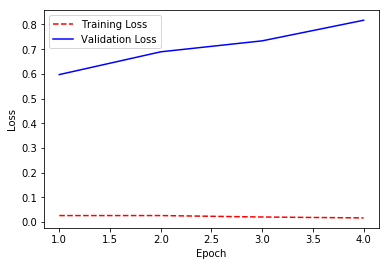

In [188]:
# Visualize the learning curve.

plt.plot(epoch_count,history.history['loss'],'r--')
plt.plot(epoch_count,history.history['val_loss'],'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [189]:
# Evaluate model
acc,score = model.evaluate(X_val,y_val,verbose=1)


4956/4956 [==============================] - 10s 2ms/step


In [190]:
print(f"Accuracy {acc*100}, Score {score*100}")

Accuracy 81.71823324035789, Score 86.92493948174447
